### Description
This notebook demonstrates how to compute the cloud feedback using cloud radiative kernels in an illustrative climate model (GFDL-CM4) using the difference between amip-p4K vs amip simulations. Additionally, this script demonstrates how to compute the Zelinka et al (2013) decomposition of cloud feedback into components due to changes in cloud amount, altitude, optical depth, and a residual, and does this separately for low and non-low clouds following Zelinka et al (2016). Finally, it includes calculations to account for changes in obscuration of low clouds by upper-level clouds as discussed in Zelinka et al (2022).

### Input
- tas,rsdscs,rsuscs,wap,clisccp
- cloud radiative kernels

### History
This code is updated from the v1.0 release (Sep 17, 2021):
  - all calls to CDAT functions replaced with xarray and xcdat
  - code refactored and cleaned up in a variety of places 
  - Li-Wei Chao (LLNL) assisted with the conversion from cdat to xarray/xcdat

### References
- Zelinka, M. D., S. A. Klein, and D. L. Hartmann, 2012: [Computing and Partitioning Cloud Feedbacks Using 
    Cloud Property Histograms. Part I: Cloud Radiative Kernels](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-11-00248.1). J. Climate, 25, 3715-3735. 
    doi:10.1175/JCLI-D-11-00248.1.
- Zelinka, M. D., S. A. Klein, and D. L. Hartmann, 2012: [Computing and Partitioning Cloud Feedbacks Using 
    Cloud Property Histograms. Part II: Attribution to Changes in Cloud Amount, Altitude, and Optical Depth](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-11-00249.1). 
    J. Climate, 25, 3736-3754. doi:10.1175/JCLI-D-11-00249.1.
- Zelinka, M.D., S.A. Klein, K.E. Taylor, T. Andrews, M.J. Webb, J.M. Gregory, and P.M. Forster, 2013: 
    [Contributions of Different Cloud Types to Feedbacks and Rapid Adjustments in CMIP5](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-12-00555.1). 
    J. Climate, 26, 5007-5027. doi:10.1175/JCLI-D-12-00555.1.
- Zelinka, M. D., C. Zhou, and S. A. Klein, 2016: [Insights from a Refined Decomposition of Cloud Feedbacks](http://onlinelibrary.wiley.com/doi/10.1002/2016GL069917/full), 
    Geophys. Res. Lett., 43, 9259-9269, doi:10.1002/2016GL069917.
- Zhou, C., M. D. Zelinka, A. E. Dessler, P. Yang, 2013: [An analysis of the short-term cloud feedback using MODIS data](http://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-12-00547.1), J. Climate, 26, 4803–4815. doi:10.1175/JCLI-D-12-00547.1.
- Zelinka et al. (2022): [Evaluating climate models’ cloud feedbacks against expert judgement](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JD035198), _J. Geophys. Res._, 127, e2021JD035198, doi:10.1029/2021JD035198.
    
### Contact
- Mark Zelinka (zelinka1@llnl.gov)

### User Input

In [1]:
model = 'GFDL-CM4'
variant = 'r1i1p1f1'
path = '/p/css03/esgf_publish/CMIP6'

### Import useful functions

In [2]:
import cal_CloudRadKernel_xr as CRK
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xsearch as xs
import xarray as xr
import numpy as np
import warnings
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Get filepaths based on user input

In [3]:
variables = ['tas','rsdscs','rsuscs','wap','clisccp'] # necessary for cloud feedback calcs
exps = ['amip','amip-p4K']
era = 'CMIP6' # user choice
filepath={}
for exp in exps:
    filepath[exp]={}   
    for var in variables:
        filepath[exp][var]={}
        if var=='clisccp':
            table='CFmon'
        else:
            table='Amon'
        pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, cmipTable=table, realm='atmos', model=model, member=variant)
        dpath=list(pathDict.keys())
        if len(dpath)==1:
            filepath[exp][var] = dpath[0]
        else:
            stop # need to investigate why more than one path survived...

### Do all the cloud feedback calculations

In [4]:
(output,obsc_output) = CRK.CloudRadKernel(filepath) 

get data
amip
  tas
  rsdscs
  rsuscs
  clisccp
amip-p4K
  tas
  rsdscs
  rsuscs
  clisccp
get LW and SW kernel
Compute feedbacks
    for section ALL
    for section HI680
    for section LO680
Get Obscuration Terms


2024-01-23 20:52:03,657 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-01-23 20:52:03,657 [WARNING]: bounds.py(create_bounds:931) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


### Standard cloud feedbacks (as diagnosed in Zelinka et al 2012b, 2013)

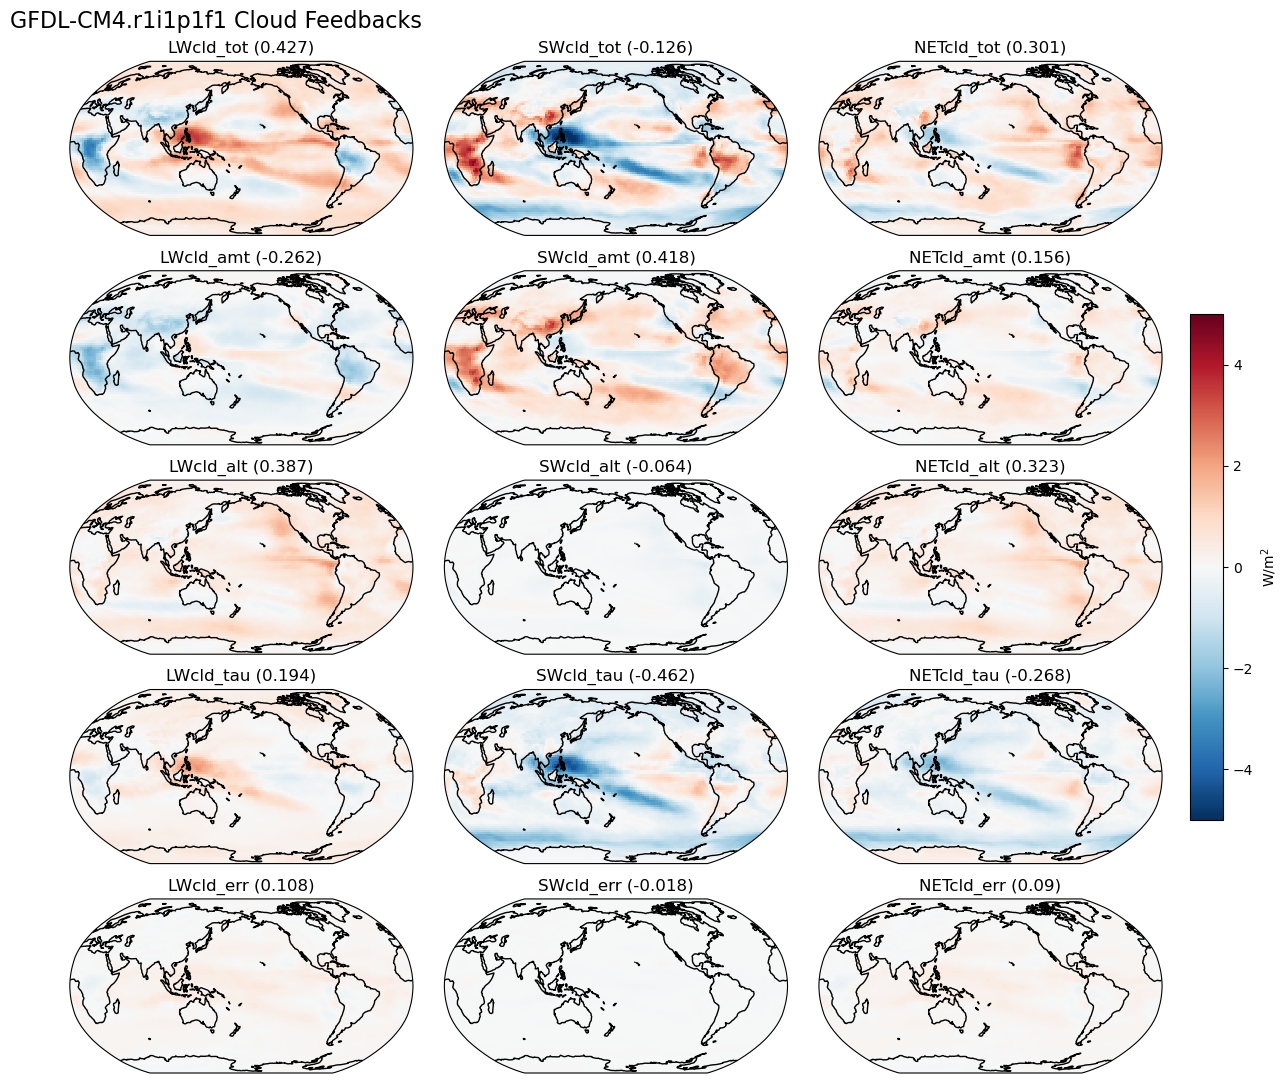

In [5]:
sec = 'ALL' # Use the full histogram
DS = xr.Dataset(output[sec])
fig = plt.figure(figsize = (14,11))
plt.suptitle(model+'.'+variant+' Cloud Feedbacks',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=5, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
cnt=-1
for row in range(5):
    for col in range(3):
        cnt+=1
        var = fields[cnt]
        avgmap = DS.mean('time')
        avgmap=avgmap.bounds.add_missing_bounds()
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -5, vmax =  5, 
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout()
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

### Separately consider the feedbacks from low clouds (CTP>680hPa) and non-low clouds (CTP<680hPa), following Zelinka et al (2016)

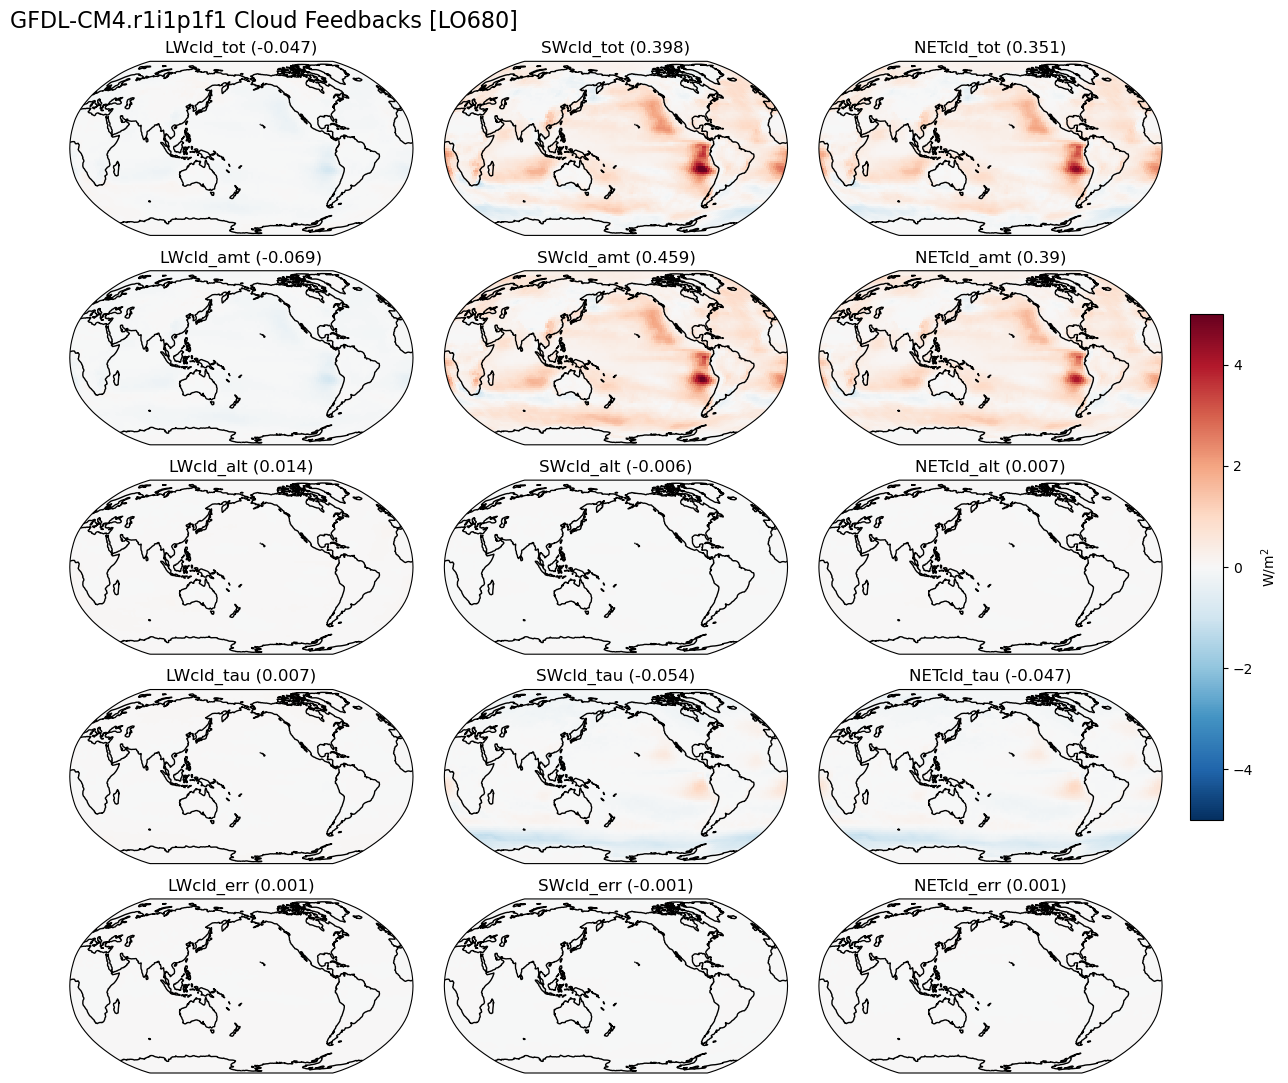

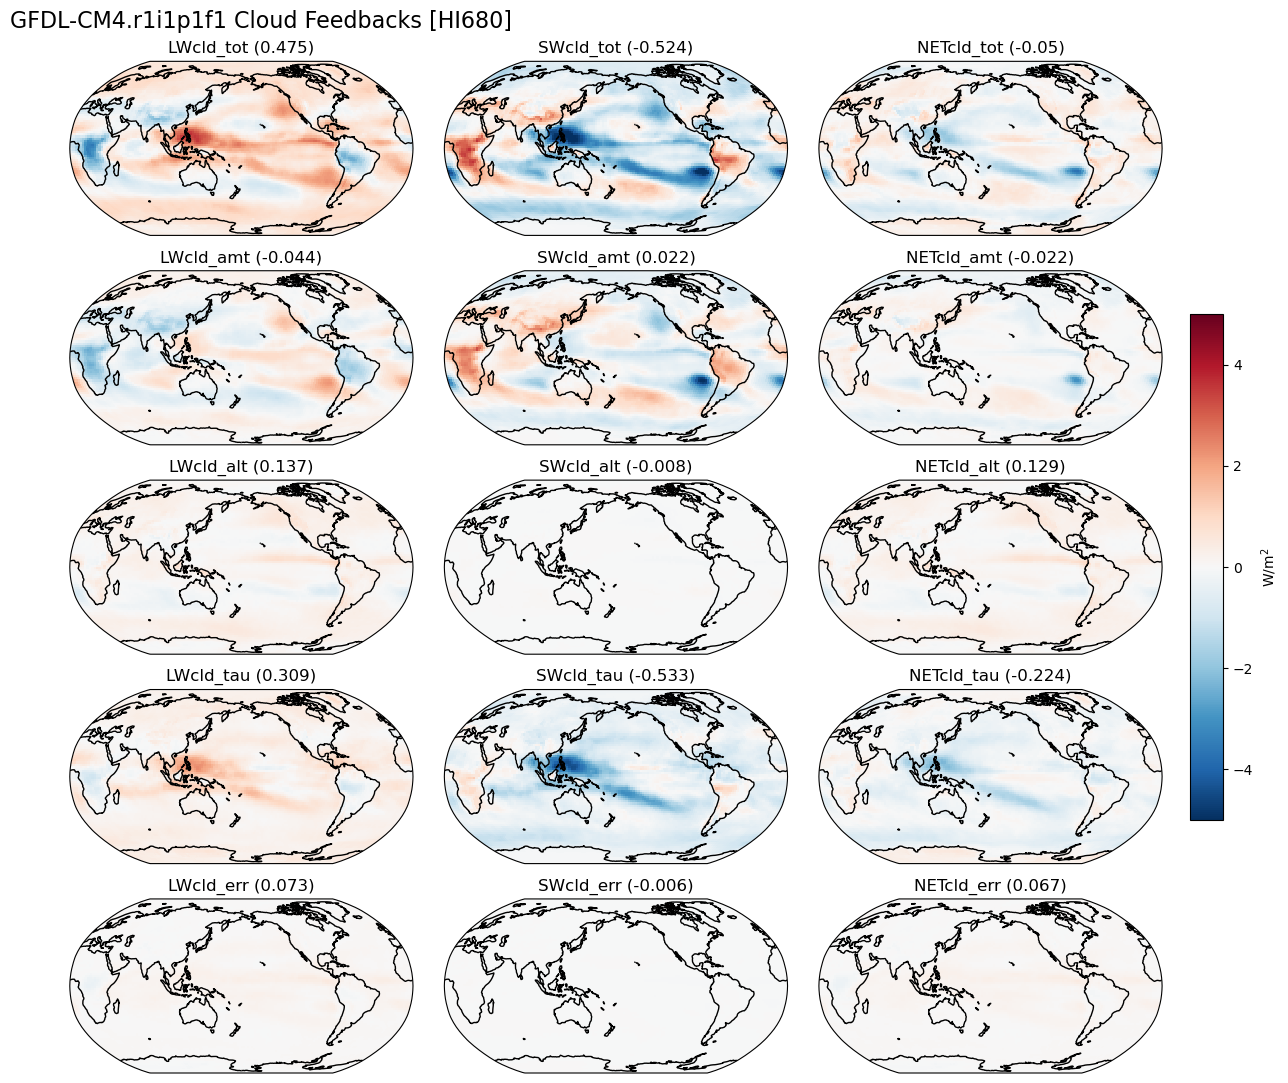

In [6]:
for sec in ['LO680','HI680']: # low and non-low separately
    DS = xr.Dataset(output[sec])
    fig = plt.figure(figsize = (14,11))
    plt.suptitle(model+'.'+variant+' Cloud Feedbacks ['+sec+']',fontsize=16,x=0,ha='left')
    axes = fig.subplots(nrows=5, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    fields = list(DS.data_vars)
    cnt=-1
    for row in range(5):
        for col in range(3):
            cnt+=1
            var = fields[cnt]
            avgmap = DS.mean('time')
            avgmap=avgmap.bounds.add_missing_bounds()
            avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
            pl = avgmap[var].plot(ax = axes[row,col], 
                      transform=ccrs.PlateCarree(),
                      vmin = -5, vmax =  5, 
                      cmap = 'RdBu_r', 
                      extend='both',                              
                      add_colorbar=False)
            axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
            axes[row,col].coastlines()
    plt.tight_layout()
    fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

### Accounting for Obscuration Effects

A portion of the feedback attributed to low clouds is in fact due to changes in obscuration by upper-level clouds. One can express the standard low-level cloud feedbacks shown above as a sum of three terms:

$$\mathrm{low = low_{unobsc} + \Delta obsc + cov}$$

Only the $\mathrm{low_{unobsc}}$ component represents a "true" low-cloud feedback occurring in regions that are not obscured by upper-level clouds and are unaffected by changes in obscuration. We further break this down into amount, altitude, optical depth, and residual components. 

$\mathrm{\Delta obsc}$ is the obscuration-induced component of low-cloud feedback arising entirely from changes in upper-level cloud fraction that reveal or hide low-level clouds. It is therefore by definition solely an amount component, so we absorb it into the high-cloud amount feedback. An example scenario where this would be important is when changes in high cloud amount occur over low-level clouds.  Rather than revealing or hiding a dark ocean (implying a potentially large high cloud amount feedback), such a response would reveal or hide bright underlying clouds (implying a potentially much weaker high cloud amount feedback).

The covariance term, $\mathrm{cov}$, is typically very small. 

To summarize, the total cloud feedback can be expressed as:

$$
\mathrm{total = \sum_i high_i + \sum_i low_{unobsc,i} + cov},
$$

where $i \in \{\mathrm{amount}, \mathrm{altitude}, \mathrm{optical\: depth}, \mathrm{residual}\}$ 
components, and the high cloud amount component includes the $\mathrm{\Delta obsc}$ component.

For more details, see [Scott et al (2020)](https://journals.ametsoc.org/view/journals/clim/33/18/jcliD191028.xml), [Myers et al (2021)](https://www.nature.com/articles/s41558-021-01039-0), and [Zelinka et al (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JD035198).

### Recommended breakdown:

#### High cloud feedbacks: 
All are taken from the standard decomposition, but the $\mathrm{\Delta obsc}$ term is added to the amount component. So the amount and total high cloud feedback are updated:

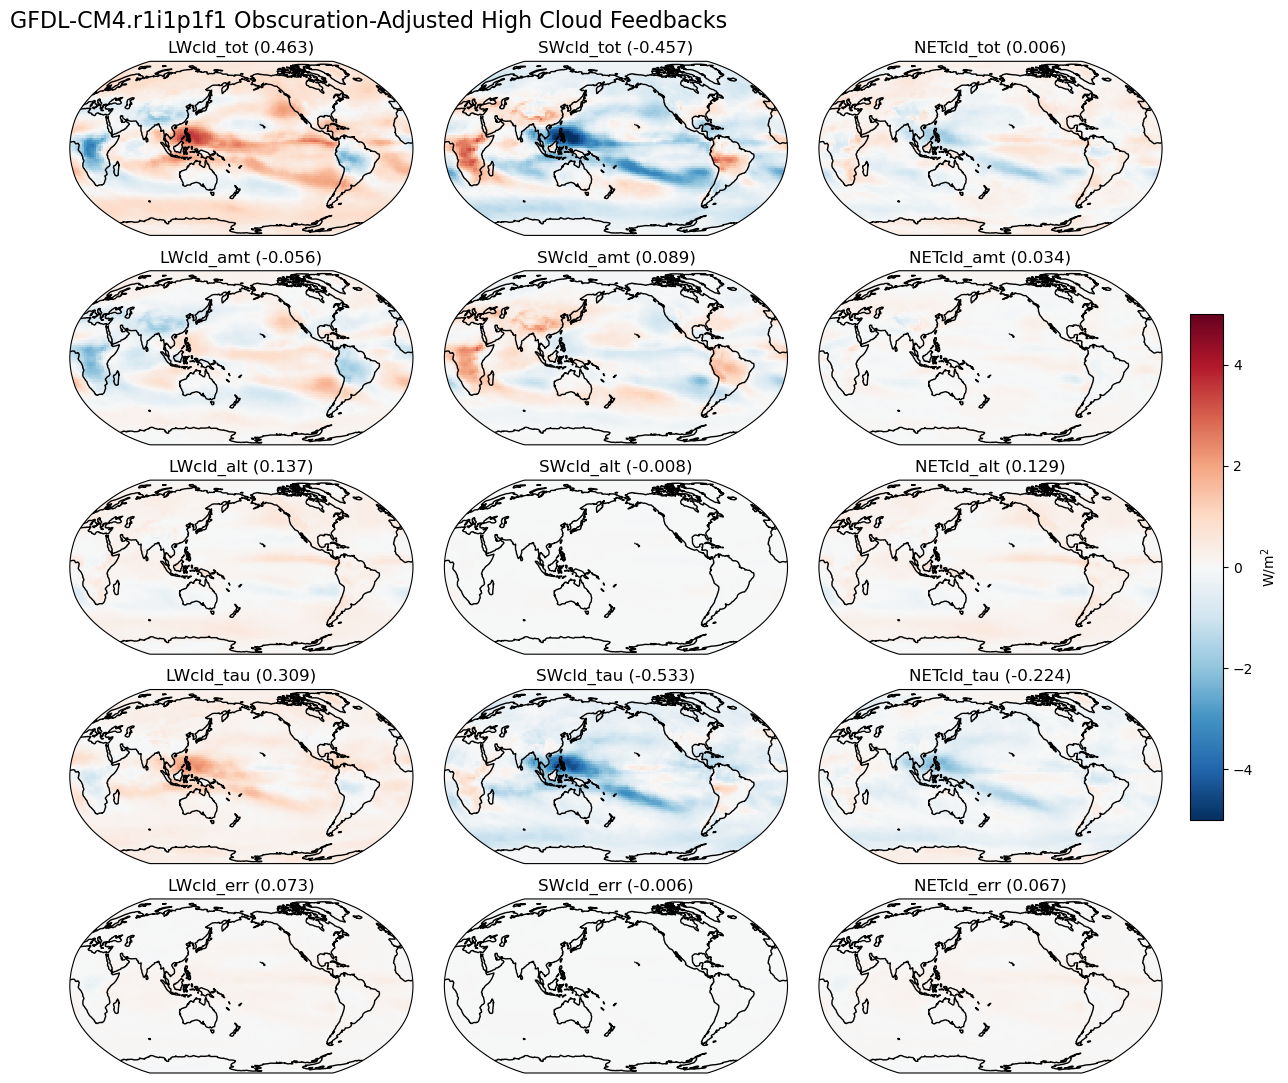

In [7]:
trueHI={}
bands=['LW','SW','NET']
fields = ['tot','amt','alt','tau','err']
for field in fields:
    for band in bands:
        trueHI[band+'cld_'+field] = copy.deepcopy(output['HI680'][band+'cld_'+field])

LOobsc = obsc_output['LO680']
# update the high cloud amount feedback to include the change in obscuration term:
trueHI['LWcld_amt'] += LOobsc['LWdobsc_fbk']
trueHI['SWcld_amt'] += LOobsc['SWdobsc_fbk']
trueHI['NETcld_amt'] = trueHI['LWcld_amt'] + trueHI['SWcld_amt']
# update the total high cloud feedback:
trueHI['LWcld_tot'] = trueHI['LWcld_amt'] + trueHI['LWcld_alt'] + trueHI['LWcld_tau'] + trueHI['LWcld_err']
trueHI['SWcld_tot'] = trueHI['SWcld_amt'] + trueHI['SWcld_alt'] + trueHI['SWcld_tau'] + trueHI['SWcld_err']
trueHI['NETcld_tot'] = trueHI['LWcld_tot'] + trueHI['SWcld_tot']

DS = xr.Dataset(trueHI)
# DS.data_vars

fig = plt.figure(figsize = (14,11))
plt.suptitle(model+'.'+variant+' Obscuration-Adjusted High Cloud Feedbacks',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=5, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
cnt=-1
for row in range(5):
    for col in range(3):
        cnt+=1
        var = fields[cnt]
        avgmap = DS.mean('time')
        avgmap=avgmap.bounds.add_missing_bounds()
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -5, vmax =  5, 
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout()
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

#### Low cloud feedbacks:
Consider only the unobscured low cloud components, and include the obscuration covariance term as part of the kernel residual term:

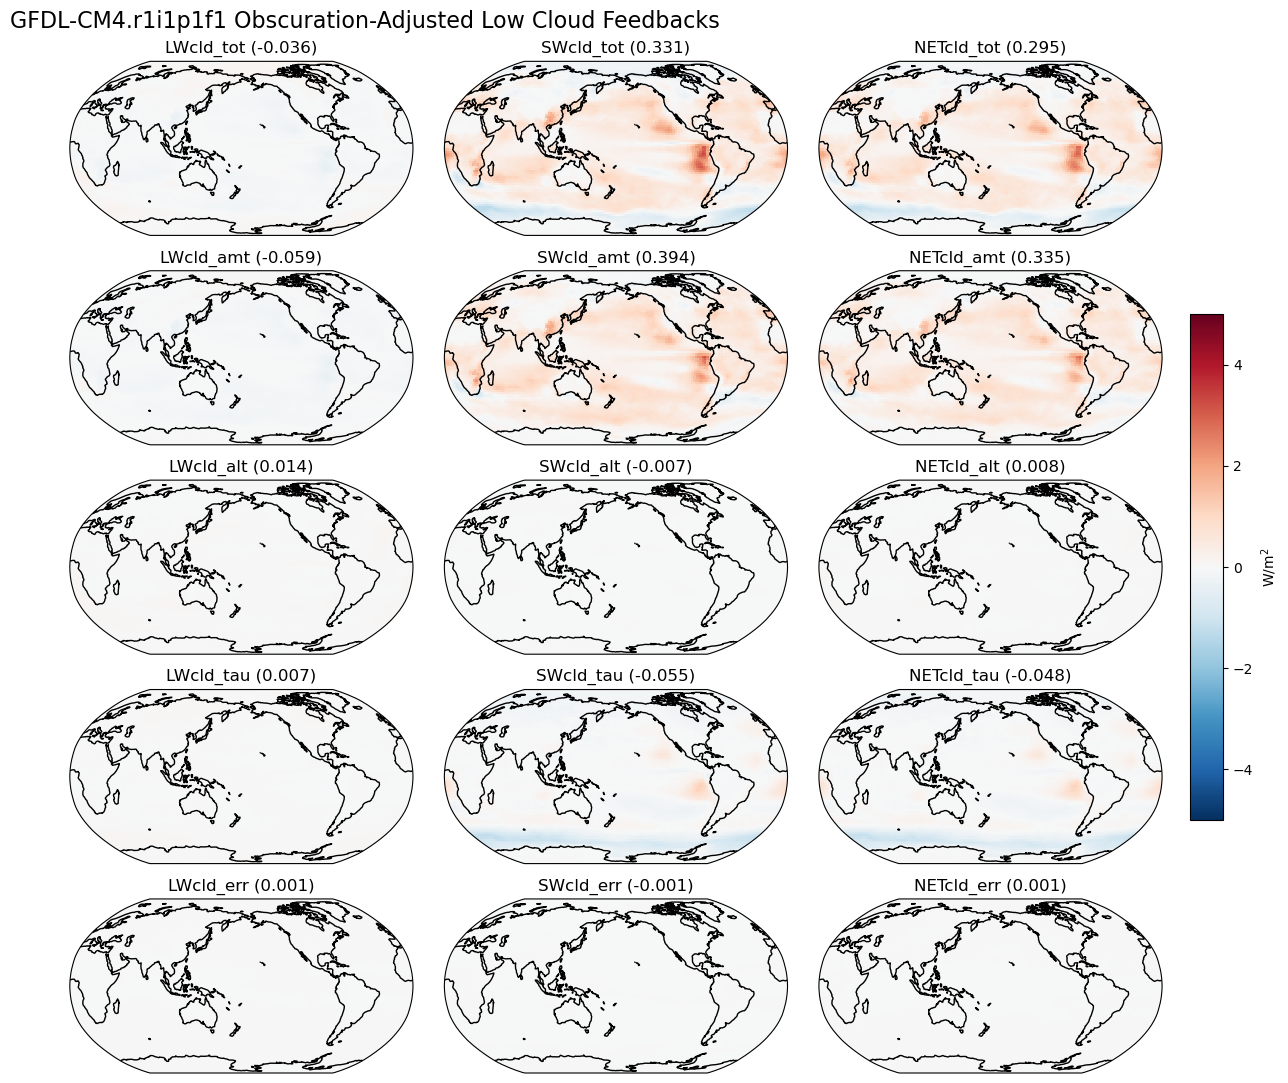

In [8]:
LOobsc = obsc_output['LO680']
# SWcld_tot is equivalent to SWdunobsc_fbk; ditto for LW compoent
# SWdobsc_fbk is already incorporated into high cloud amount feedback; ditto for LW component

trueLO={}
bands=['LW','SW','NET']
fields = ['tot','amt','alt','tau','err']
for field in fields:
    for band in bands:
        trueLO[band+'cld_'+field] = copy.deepcopy(LOobsc[band+'cld_'+field])
# include the obscuration covariance term with the kernel residual:
trueLO['LWcld_err'] += LOobsc['LWdobsc_cov_fbk']
trueLO['SWcld_err'] += LOobsc['SWdobsc_cov_fbk']
trueLO['NETcld_err'] = trueLO['LWcld_err']+trueLO['SWcld_err']
# update the total low cloud feedback:
trueLO['LWcld_tot'] = trueLO['LWcld_amt'] + trueLO['LWcld_alt'] + trueLO['LWcld_tau'] + trueLO['LWcld_err']
trueLO['SWcld_tot'] = trueLO['SWcld_amt'] + trueLO['SWcld_alt'] + trueLO['SWcld_tau'] + trueLO['SWcld_err']
trueLO['NETcld_tot'] = trueLO['LWcld_tot'] + trueLO['SWcld_tot']

DS = xr.Dataset(trueLO)
# DS.data_vars

fig = plt.figure(figsize = (14,11))
plt.suptitle(model+'.'+variant+' Obscuration-Adjusted Low Cloud Feedbacks',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=5, ncols=3, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
cnt=-1
for row in range(5):
    for col in range(3):
        cnt+=1
        var = fields[cnt]
        avgmap = DS.mean('time')
        avgmap=avgmap.bounds.add_missing_bounds()
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -5, vmax =  5, 
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout()
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

### Show a few more comparisons and sanity checks

In [9]:
ALL = xr.Dataset(output['ALL'])
LO = xr.Dataset(output['LO680'])
HI = xr.Dataset(output['HI680'])
trueLO = xr.Dataset(trueLO)
trueHI = xr.Dataset(trueHI)

Text(0.5, 1.0, 'd) a - c (should equal b)')

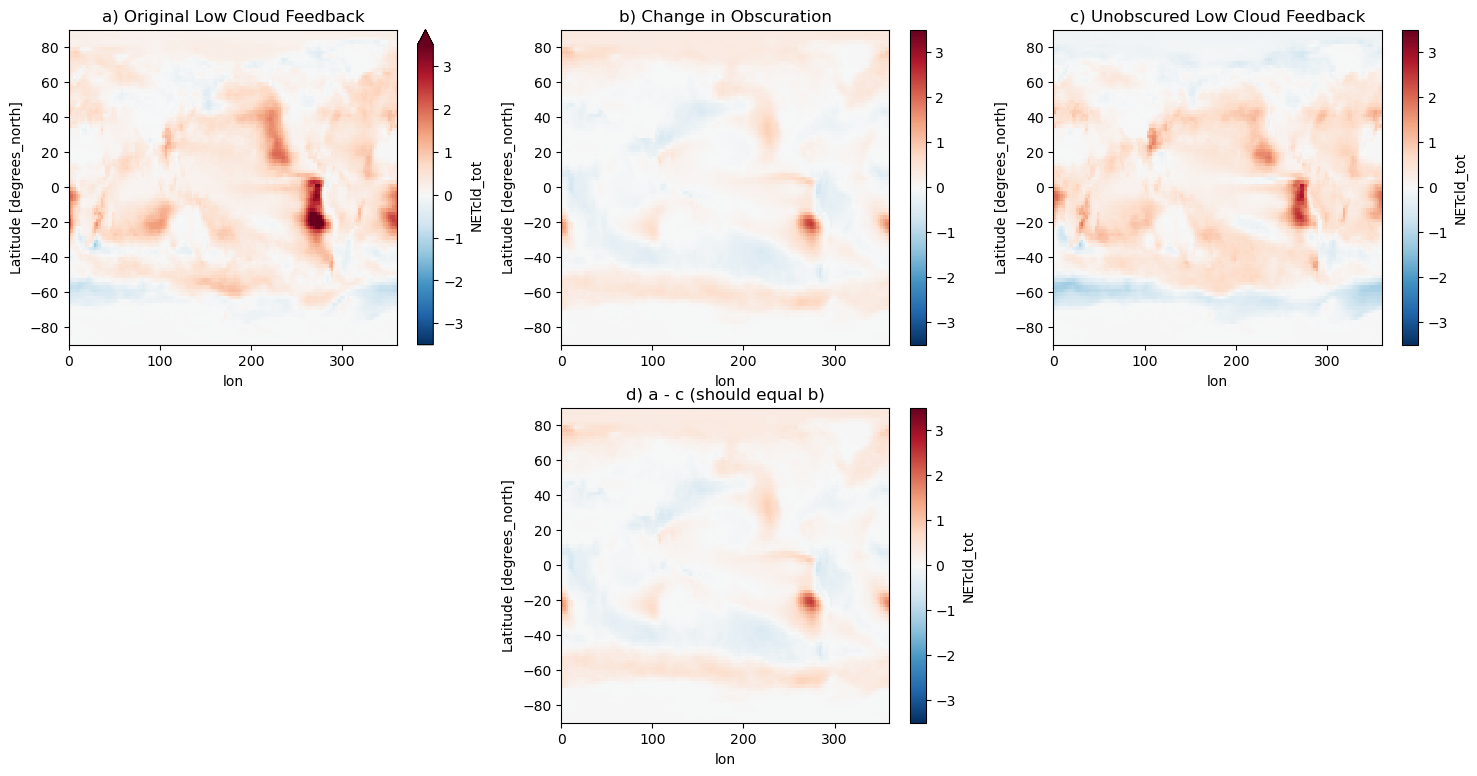

In [10]:
# Verify that the unobscured low cloud feedback = original low cloud feedback + change in obscuration:
plt.figure(figsize=(18,9))
plt.subplot(2,3,1)
A = LO['NETcld_tot'].mean('time')
A.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('a) Original Low Cloud Feedback')
plt.subplot(2,3,2)
B = (LOobsc['LWdobsc_fbk']+LOobsc['SWdobsc_fbk']).mean('time')
B.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('b) Change in Obscuration')
plt.subplot(2,3,3)
C = trueLO['NETcld_tot'].mean('time')
C.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('c) Unobscured Low Cloud Feedback')
plt.subplot(2,3,5)
D = A-C
D.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('d) a - c (should equal b)')

Text(0.5, 1.0, 'd) a+b (should equal c)')

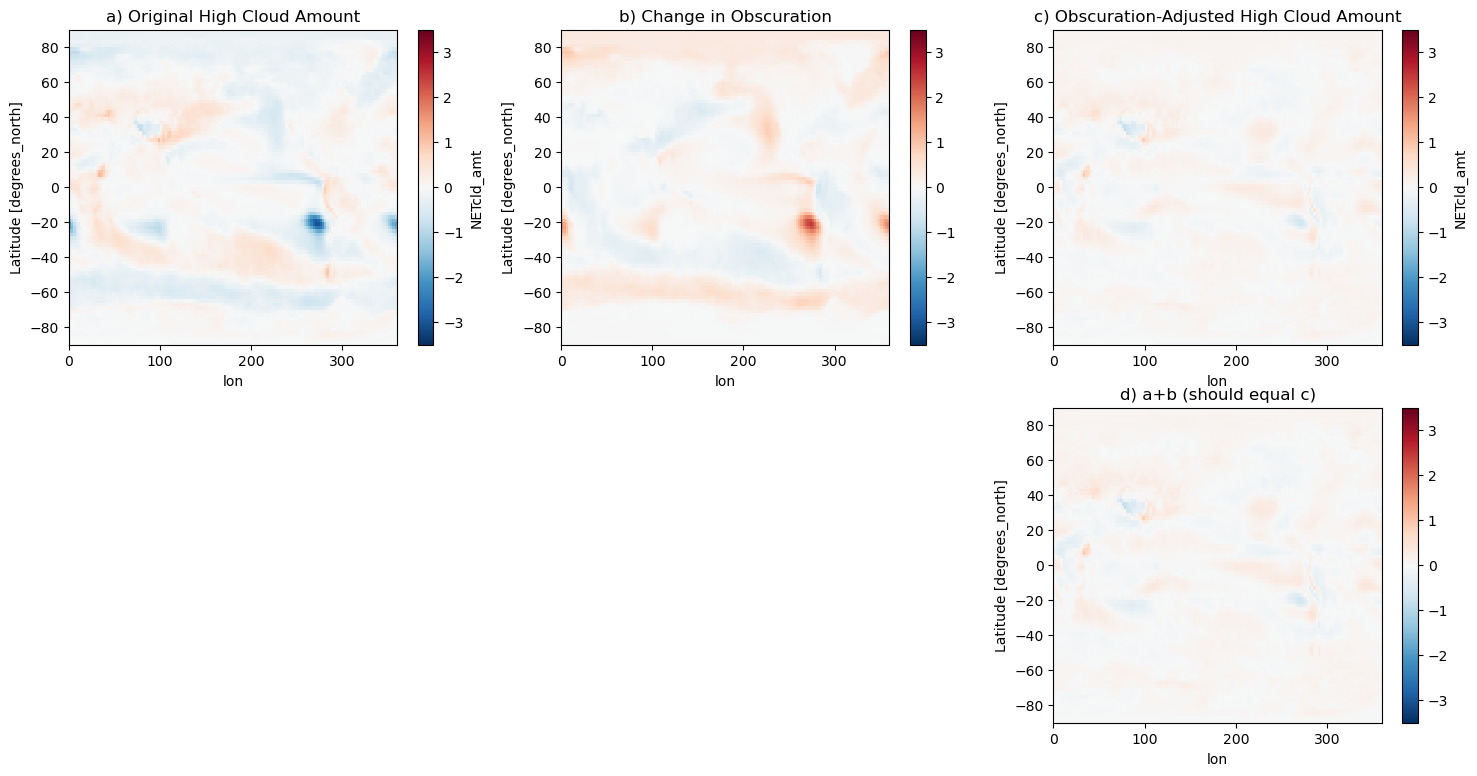

In [11]:
# Verify that the obscuration-adjusted high cloud amount feedback = original high cloud amount feedback + change in obscuration:
plt.figure(figsize=(18,9))
plt.subplot(2,3,1)
A = HI['NETcld_amt'].mean('time')
A.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('a) Original High Cloud Amount')
plt.subplot(2,3,2)
B = (LOobsc['LWdobsc_fbk']+LOobsc['SWdobsc_fbk']).mean('time')
B.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('b) Change in Obscuration')
plt.subplot(2,3,3)
C = trueHI['NETcld_amt'].mean('time')
C.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('c) Obscuration-Adjusted High Cloud Amount')
plt.subplot(2,3,6)
D = A+B
D.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('d) a+b (should equal c)')

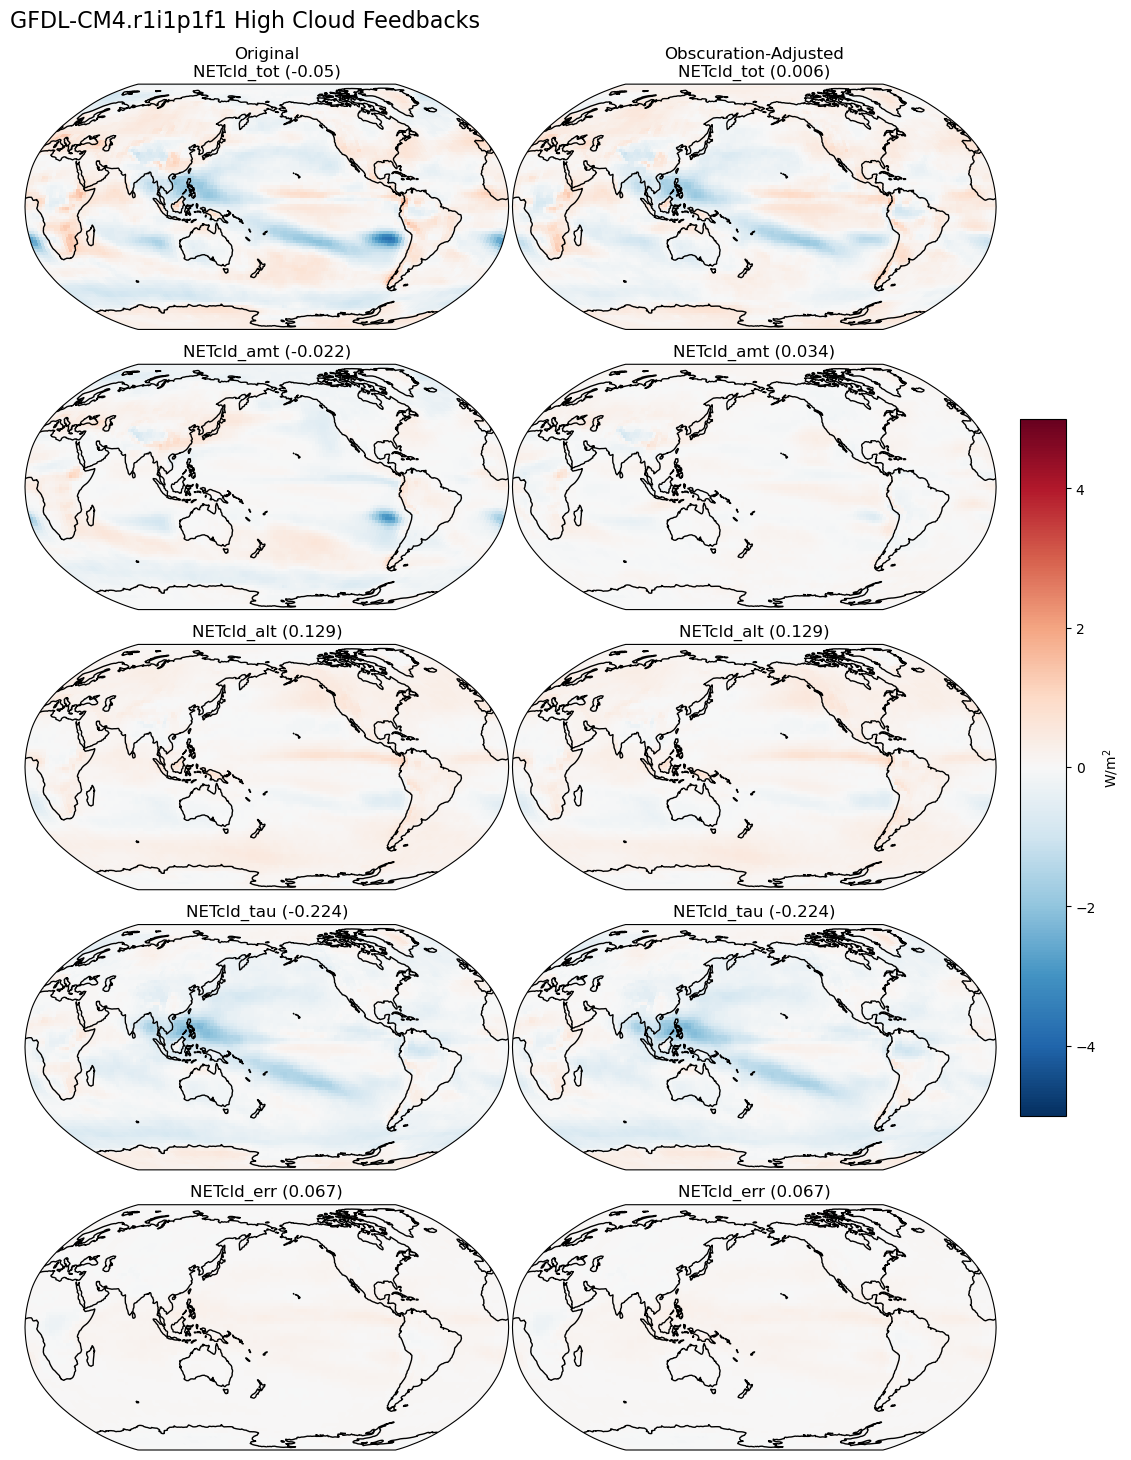

In [19]:
# Compare original and obscuration-adjusted high cloud feedbacks:
fig = plt.figure(figsize = (12,15))
plt.suptitle(model+'.'+variant+' High Cloud Feedbacks',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=5, ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
for col,DS in enumerate([HI,trueHI]):
    row=-1
    for var in fields:
        if 'NET' not in var:
            continue
        row+=1
        avgmap = DS.mean('time')
        avgmap=avgmap.bounds.add_missing_bounds()
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -5, vmax =  5, 
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        if row==0:
            if col==0:
                axes[row,col].set_title('Original\n'+var+" (" + str(np.round(avg,3)) + ")")
            else:
                axes[row,col].set_title('Obscuration-Adjusted\n'+var+" (" + str(np.round(avg,3)) + ")")
        else:
            axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-1)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

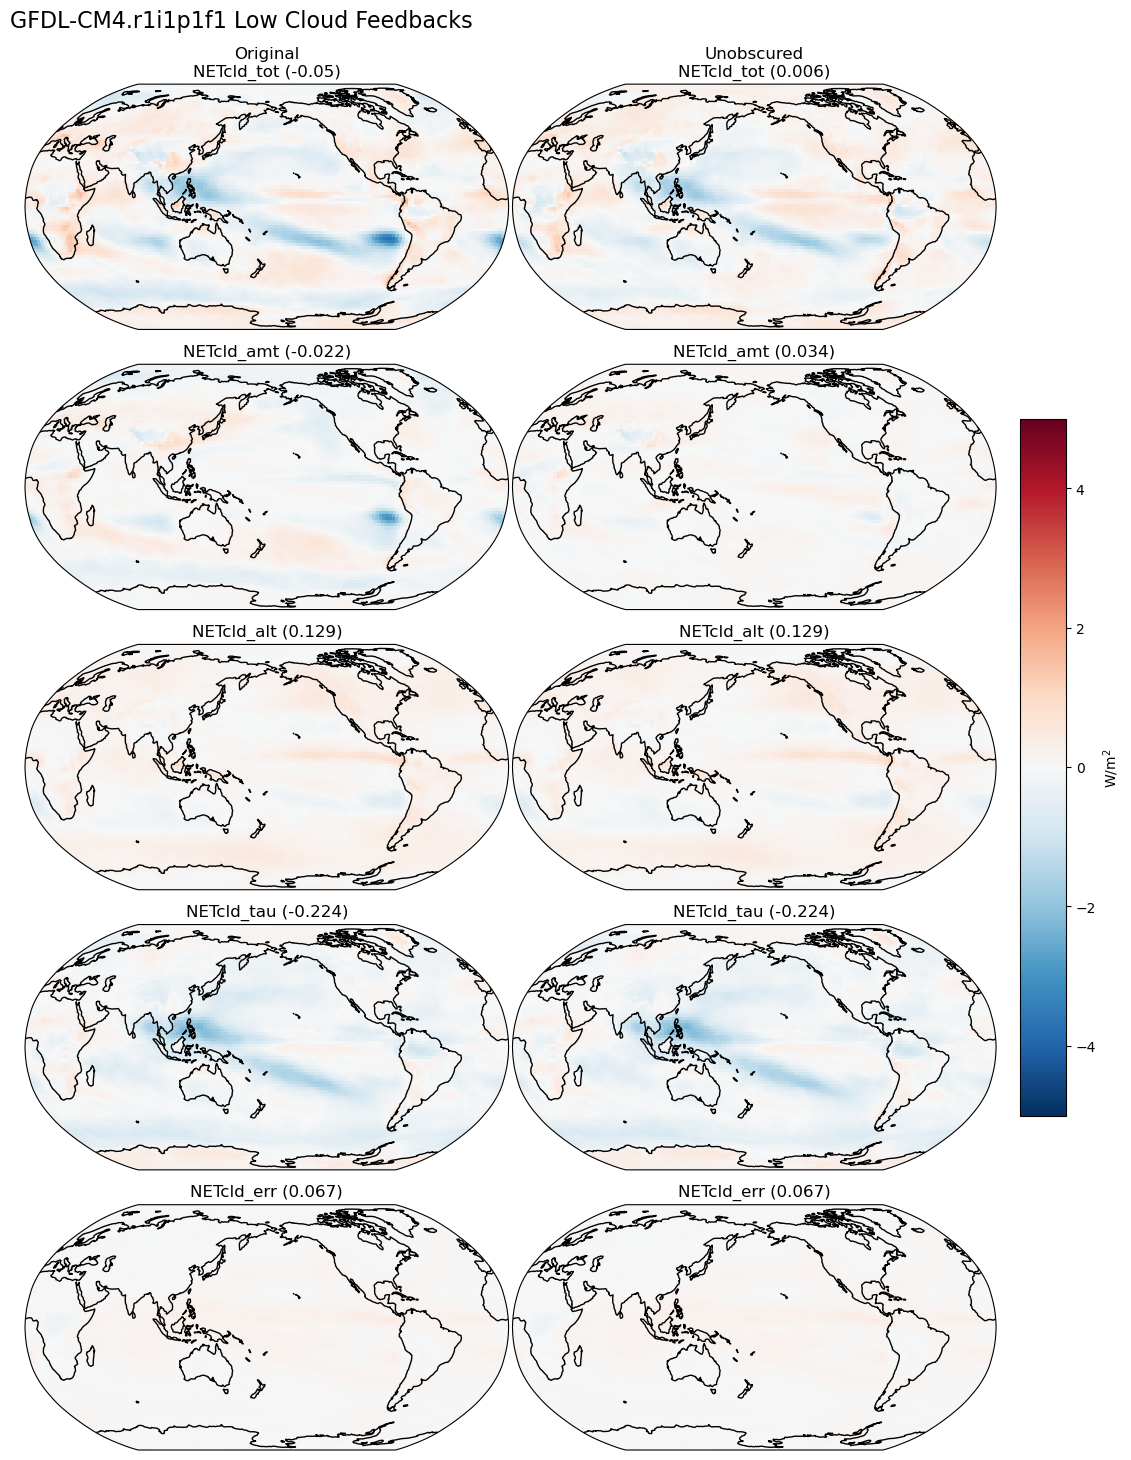

In [20]:
# Compare original and unobscured low cloud feedbacks:
fig = plt.figure(figsize = (12,15))
plt.suptitle(model+'.'+variant+' Low Cloud Feedbacks',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=5, ncols=2, subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
fields = list(DS.data_vars)
for col,DS in enumerate([HI,trueHI]):
    row=-1
    for var in fields:
        if 'NET' not in var:
            continue
        row+=1
        avgmap = DS.mean('time')
        avgmap=avgmap.bounds.add_missing_bounds()
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -5, vmax =  5, 
                  cmap = 'RdBu_r', 
                  extend='both',                              
                  add_colorbar=False)
        if row==0:
            if col==0:
                axes[row,col].set_title('Original\n'+var+" (" + str(np.round(avg,3)) + ")")
            else:
                axes[row,col].set_title('Unobscured\n'+var+" (" + str(np.round(avg,3)) + ")")
        else:
            axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-1)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

Text(0.5, 1.0, 'f) i-d (should be zero)')

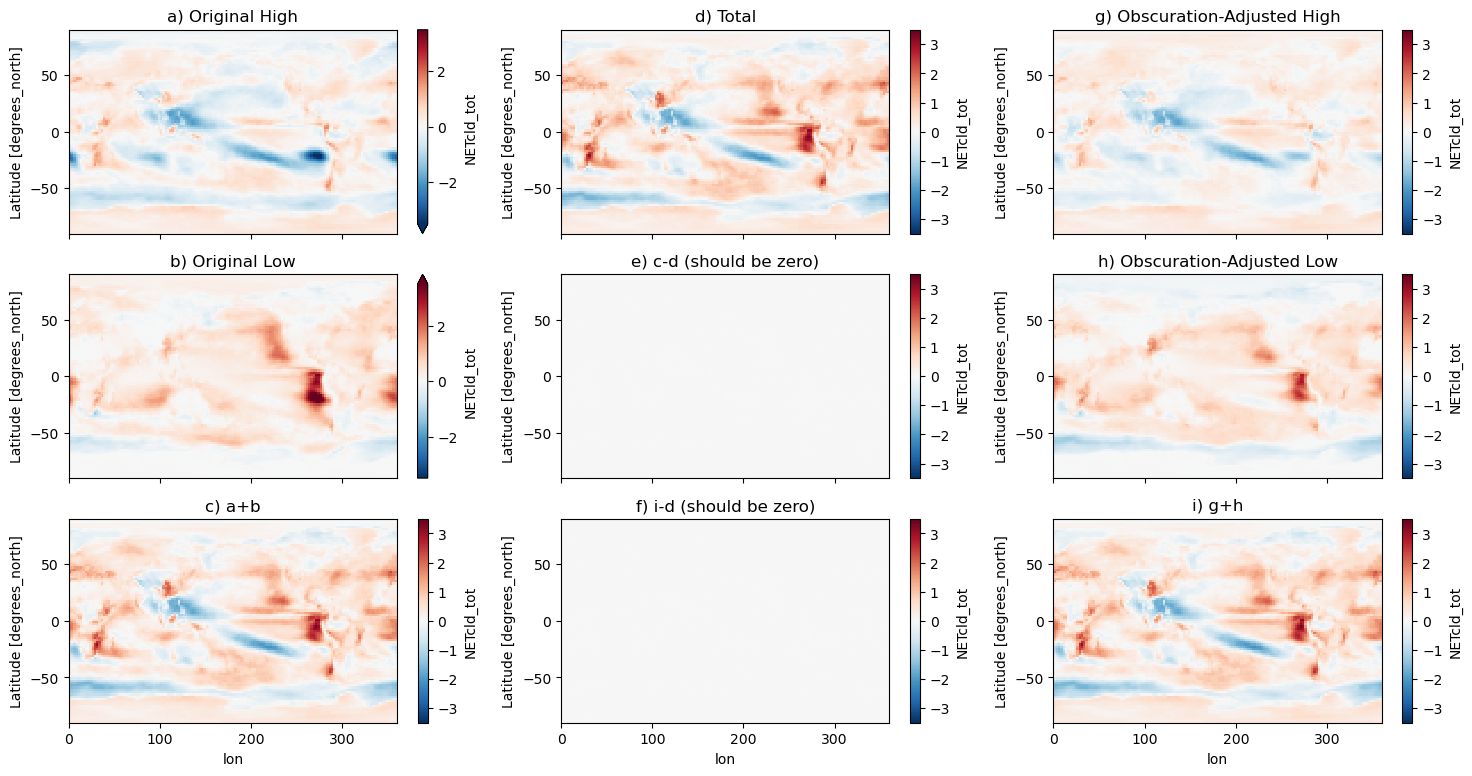

In [14]:
# Verify that the sum of total "original" feedbacks are equivalent to the sum of total "obscuration-adjusted" feedbacks, 
# and that these are both equivalent to the original total feedback considering all cloud types (i.e., not doing the low vs non-low decomposition)
plt.figure(figsize=(18,9))
ax = plt.subplot(3,3,1)
A = HI['NETcld_tot'].mean('time')
A.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('a) Original High')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,4)
B = LO['NETcld_tot'].mean('time')
B.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('b) Original Low')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,7)
C = A+B
C.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('c) a+b')

ax = plt.subplot(3,3,3)
G = trueHI['NETcld_tot'].mean('time')
G.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('g) Obscuration-Adjusted High')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,6)
H = trueLO['NETcld_tot'].mean('time')
H.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('h) Obscuration-Adjusted Low')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,9)
I = A+B
I.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('i) g+h')

# truth:
ax = plt.subplot(3,3,2)
D = ALL['NETcld_tot'].mean('time')
D.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('d) Total')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,5)
E = C-D
E.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('e) c-d (should be zero)')
ax.set_xticklabels([])
ax.set_xlabel('')
ax = plt.subplot(3,3,8)
F = I-D
F.plot(vmin=-3.5,vmax=3.5,cmap='RdBu_r')
plt.title('f) i-d (should be zero)')